Import libraries and load data

In [28]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

Load and prepare dataset

In [29]:
df = pd.read_csv("final_data.csv")
df = df.rename(columns={"text": "phrase", "LABEL": "label"})
df = df[["phrase", "label"]].dropna()

# Map labels to integers
unique_labels = df["label"].unique().tolist()
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for i, label in enumerate(unique_labels)}
df["label_id"] = df["label"].map(label2id)

# Sample fewer rows per class
df_sampled = df.groupby("label").apply(lambda x: x.sample(n=30, random_state=42)).reset_index(drop=True)
train_df, test_df = train_test_split(df_sampled, test_size=0.2, random_state=42)

/tmp/ipykernel_5785/2794514627.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby("label").apply(lambda x: x.sample(n=30, random_state=42)).reset_index(drop=True)


Define Custom Dataset

In [30]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(self.texts[idx],
                                 truncation=True,
                                 padding="max_length",
                                 max_length=self.max_len,
                                 return_tensors="pt")
        item = {key: val.squeeze(0) for key, val in encoded.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item


Tokenizer, DataLoader

In [31]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_dataset = TextDataset(train_df["phrase"].tolist(), train_df["label_id"].tolist(), tokenizer)
test_dataset = TextDataset(test_df["phrase"].tolist(), test_df["label_id"].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

Model, Optimizer, Device

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(unique_labels)
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Loop

In [33]:
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")


Epoch 1: 100%|██████████| 24/24 [02:41<00:00,  6.74s/it]


Epoch 1 | Loss: 2.1278


Epoch 2: 100%|██████████| 24/24 [02:37<00:00,  6.56s/it]


Epoch 2 | Loss: 2.0501


Epoch 3: 100%|██████████| 24/24 [02:37<00:00,  6.55s/it]

Epoch 3 | Loss: 1.9113


Save Model for Robustness Testing

In [34]:
model.save_pretrained("robustness_model_pytorch")
tokenizer.save_pretrained("robustness_model_pytorch")

('robustness_model_pytorch/tokenizer_config.json',
 'robustness_model_pytorch/special_tokens_map.json',
 'robustness_model_pytorch/vocab.txt',
 'robustness_model_pytorch/added_tokens.json')

Load model & define predict function

In [35]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load your fine-tuned model
model = BertForSequenceClassification.from_pretrained("robustness_model_pytorch").to(device)
tokenizer = BertTokenizer.from_pretrained("robustness_model_pytorch")
model.eval()

# Predict function
def predict(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
    return preds


Generate adversarial samples

In [36]:
# Add irrelevant sentence
def insert_irrelevant(text):
    return "My cat is fluffy. " + text

# Add spelling noise
def spelling_noise(text):
    return text.replace("pain", "painn").replace("hurt", "hurrt")

# Create copies
original_texts = test_df["phrase"].tolist()
true_labels = test_df["label_id"].tolist()

insert_texts = [insert_irrelevant(t) for t in original_texts]
noise_texts = [spelling_noise(t) for t in original_texts]

Make predictions & evaluate robustness

In [37]:
# Get predictions
original_preds = predict(original_texts)
insert_preds = predict(insert_texts)
noise_preds = predict(noise_texts)

# Define evaluation
def consistency(p1, p2):
    return np.mean(p1 == p2)

def acc(preds, labels):
    return accuracy_score(labels, preds)

# Print results
print("Original Accuracy:", acc(original_preds, true_labels))
print("Insert Consistency:", consistency(original_preds, insert_preds))
print("Spelling Consistency:", consistency(original_preds, noise_preds))

Original Accuracy: 0.22916666666666666
Insert Consistency: 0.8125
Spelling Consistency: 0.9583333333333334


Save prediction results

In [38]:
test_df["original_pred"] = [id2label[i] for i in original_preds]
test_df["insert_pred"] = [id2label[i] for i in insert_preds]
test_df["noise_pred"] = [id2label[i] for i in noise_preds]

test_df.to_csv("robustness_predictions.csv", index=False)
print("Saved to robustness_predictions.csv ✅")

Saved to robustness_predictions.csv ✅


Plot Confusion Matrices for Prediction Comparison

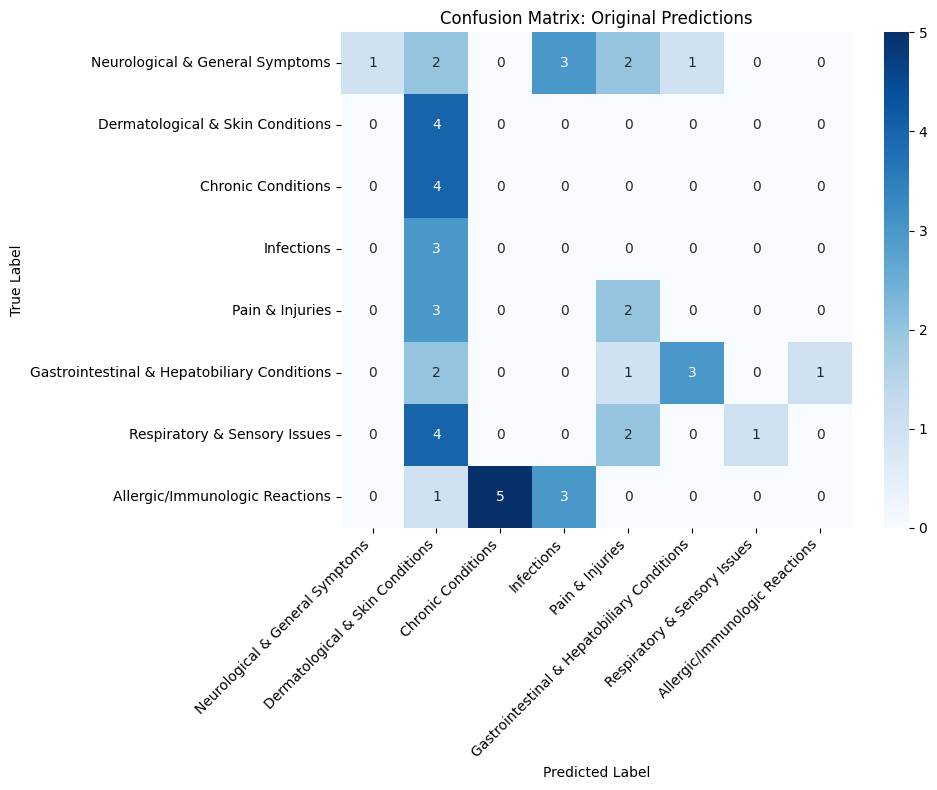

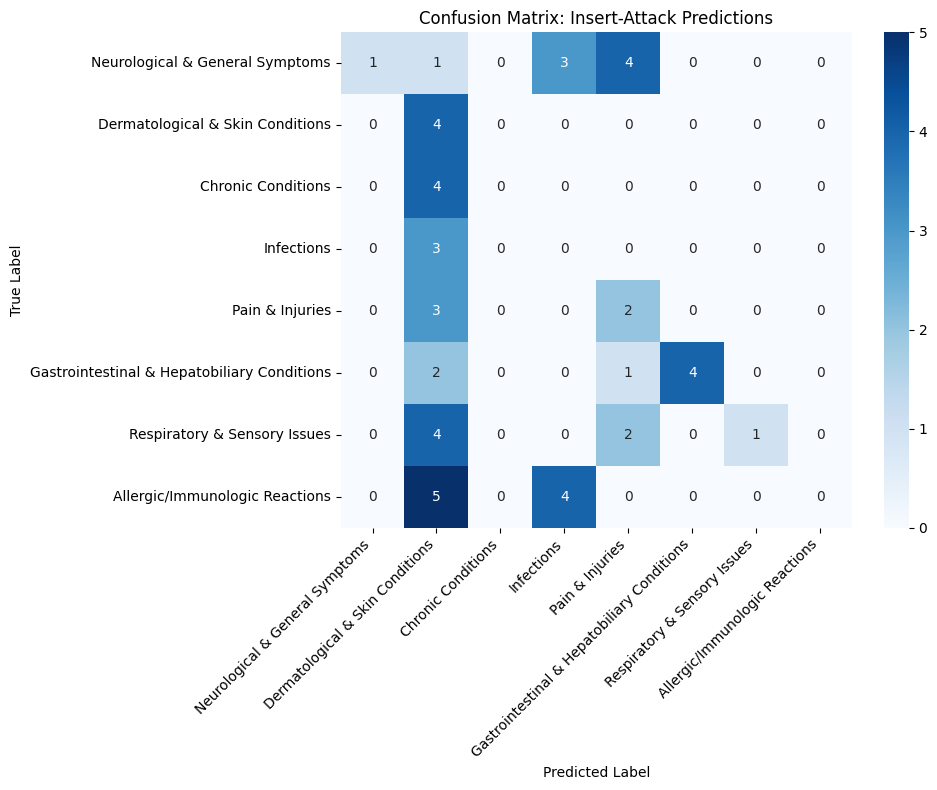

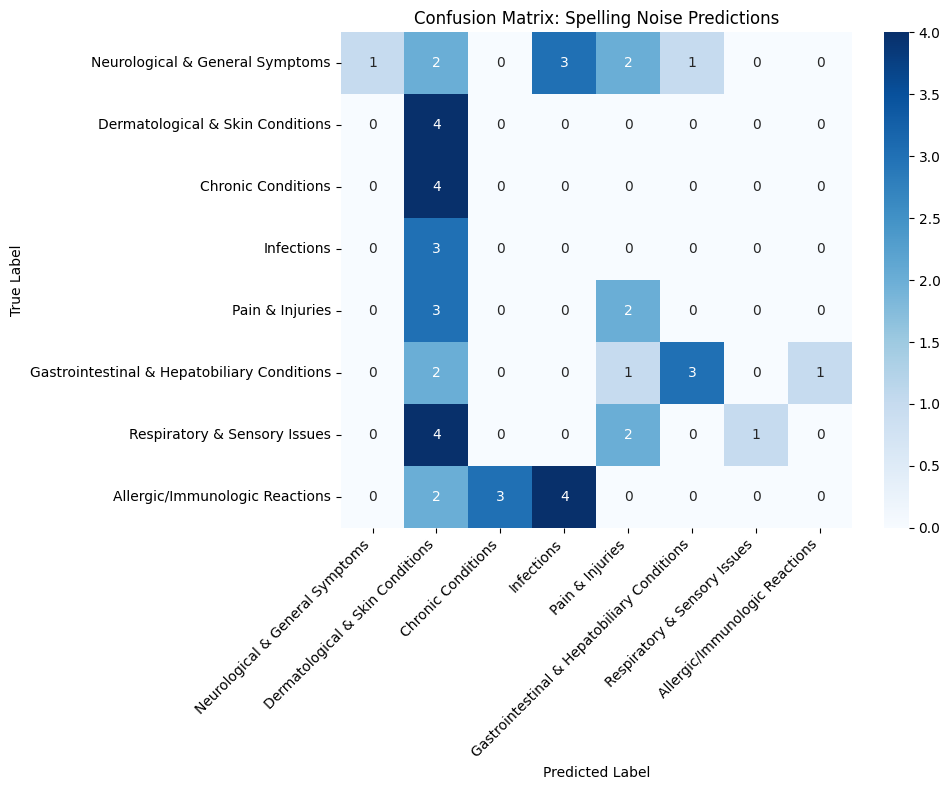

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true, pred, title):
    cm = confusion_matrix(true, pred, labels=list(id2label.keys()))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=list(id2label.values()), 
                yticklabels=list(id2label.values()))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(true_labels, original_preds, "Confusion Matrix: Original Predictions")
plot_confusion_matrix(true_labels, insert_preds, "Confusion Matrix: Insert-Attack Predictions")
plot_confusion_matrix(true_labels, noise_preds, "Confusion Matrix: Spelling Noise Predictions")


Synonym Replacement Attack

In [40]:
# Simple synonym replacement dictionary
synonyms = {
    "pain": "ache",
    "headache": "migraine",
    "stomach": "belly",
    "tired": "fatigued",
    "hurt": "sore"
}

def synonym_replace(text):
    for word, synonym in synonyms.items():
        text = text.replace(word, synonym)
    return text

# Apply synonym attack
synonym_texts = [synonym_replace(t) for t in original_texts]
synonym_preds = predict(synonym_texts)

print("Synonym Replacement Consistency:", consistency(original_preds, synonym_preds))


Synonym Replacement Consistency: 0.9583333333333334


SHAP Explainability (Optional)

In [43]:
from transformers import pipeline
import shap

# Wrap model as a text classification pipeline
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Use SHAP's text explainer
explainer = shap.Explainer(pipe)
shap_values = explainer(original_texts[:3])

# Plot explanation
shap.plots.text(shap_values[0])

Device set to use cpu
PartitionExplainer explainer: 4it [03:00, 60.14s/it]                       


Print Overall Robustness Summary

In [44]:
print("=== Adversarial Robustness Evaluation Summary ===")
print(f"Original Accuracy: {acc(original_preds, true_labels):.4f}")
print(f"Insert-Attack Consistency: {consistency(original_preds, insert_preds):.4f}")
print(f"Spelling-Attack Consistency: {consistency(original_preds, noise_preds):.4f}")
print(f"Synonym-Attack Consistency: {consistency(original_preds, synonym_preds):.4f}")

=== Adversarial Robustness Evaluation Summary ===
Original Accuracy: 0.2292
Insert-Attack Consistency: 0.8125
Spelling-Attack Consistency: 0.9583
Synonym-Attack Consistency: 0.9583
